In [1]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [3]:
def continent_drop(df):
  """This function takes in a dataframe and drop any rows without
  a country code which is assumed as a continent"""
  df = df.dropna(subset=['Code'])
  df = df.reset_index(drop=True)
  return df

def zeros_column_drop(df):
  """This function takes in a dataframe and remove any column where all the
  values are 0"""
  drop_col = [] #Empty list to take in all the columns that need to be dropped
  #Creating a loop to check each column from the dataframe and append columns
  #where all values are 0 to the list.
  for col in df.columns:
    if (df[col]==0).all():
      drop_col.append(col)
  #Dropping all columns from the drop_col list
  df = df.drop(columns=drop_col)
  return df

def manage_outliers(df):
  """This function takes in an dataframe and replace outliers with lowerbound
  upperbound values"""
  #Creating a loop to check through each columns for outliers
  for col in df.columns:
    #Calculating the 1st quartile and 3rd quartile for a column
    Q1 = np.percentile(df[col], 25, method = 'midpoint')
    Q3 = np.percentile(df[col], 75, method = 'midpoint')
    #Calculating the Inter Quartile Range using Q1 and Q3
    IQR = Q3 - Q1
    #Calculating the lower bound and upper bound of the for a column
    lower = Q1 - (1.5 * IQR)
    upper = Q3 + (1.5 * IQR)
    #Using if condtition to check if any of the column value is greater than
    #upperbound or is less than lowerbound
    if df[(df[col] < lower) | (df[col] > upper)].any(axis=None):
      #Replacing values with lowerbound if the value is less than lowerbound
      df[col] = np.where(df[col] < lower, lower, df[col])
      #Replacing values with upperbound if the value is grater than upperbound
      df[col] = np.where(df[col] > upper, upper, df[col])
  return df

def manage_null_values(df):
  """This function takes in a dataframe and drops any column with more than 25%
  of data missing and replace null values using ffill() and bfill() function"""
  #Creating an empty list to append the columns that needs to be dropped
  drop_col = []
  for col in df.columns:
    if (((df[col].isna().sum()) / len(df[col])) * 100) >=25 :
      drop_col.append(col)
  df = df.drop(columns = drop_col, axis=1)
  df = df.ffill()
  df = df.bfill()
  return df

def normalise(df):
  """ Function to normalise values using standard scaler"""
  scaler = StandardScaler()
  df[['Emission', 'Fertlizer_consumption', 'Temperature']] = scaler.fit_transform(df[['Emission', 'Fertlizer_consumption', 'Temperature']])
  return df

In [4]:
#Reading the nitrous oxide emission data into a dataframe using pd.read_csv
no2_data = pd.read_csv('/content/drive/MyDrive/final_project/EML_forecast/nitrous-oxide-emissions.csv')
#Printing the first 5 records of the data
print(no2_data.head())
no2_data.describe()

        Entity Code  Year  Annual nitrous oxide emissions in CO₂ equivalents
0  Afghanistan  AFG  1850                                          223008.40
1  Afghanistan  AFG  1851                                          227659.61
2  Afghanistan  AFG  1852                                          232190.92
3  Afghanistan  AFG  1853                                          236528.19
4  Afghanistan  AFG  1854                                          240597.22


,Year,Annual nitrous oxide emissions in CO₂ equivalents
count,38060.00000,3.806000e+04
mean,1936.00000,2.505370e+07
std,49.94062,1.279464e+08
min,1850.00000,0.000000e+00
25%,1893.00000,6.872257e+04
50%,1936.00000,6.837655e+05
75%,1979.00000,4.982349e+06
max,2022.00000,2.969828e+09


In [5]:
#Renaming the column to 'Emission'
no2_data = no2_data.rename(columns = {'Annual nitrous oxide emissions in CO₂ equivalents' : 'Emission'})
#Calling the continent_remove function to drop the records which are not country
no2_data = continent_drop(no2_data)
print(no2_data)

            Entity Code  Year    Emission
0      Afghanistan  AFG  1850   223008.40
1      Afghanistan  AFG  1851   227659.61
2      Afghanistan  AFG  1852   232190.92
3      Afghanistan  AFG  1853   236528.19
4      Afghanistan  AFG  1854   240597.22
...            ...  ...   ...         ...
34941     Zimbabwe  ZWE  2018  5237749.00
34942     Zimbabwe  ZWE  2019  5149571.50
34943     Zimbabwe  ZWE  2020  4687377.50
34944     Zimbabwe  ZWE  2021  4966384.00
34945     Zimbabwe  ZWE  2022  4960561.00

[34946 rows x 4 columns]


In [6]:
#Creating a pivot table where all the countries as columns and year as index
no2_pivot = pd.pivot_table(no2_data, index='Year', columns='Entity', values = 'Emission')
print(no2_pivot)
#Checking if any of the columns contains any null values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):print(no2_pivot.isna().sum())
#Calling the zeros_column_drop function to drop any column with all values as 0
no2_pivot = zeros_column_drop(no2_pivot)

Entity  Afghanistan      Albania      Algeria     Andorra       Angola  \
Year                                                                     
1850      223008.40    43200.230    89805.220   1066.9111    470101.80   
1851      227659.61    43941.914    91520.250   1084.1968    479868.28   
1852      232190.92    44668.260    93194.836   1101.1549    489383.90   
1853      236528.19    45369.790    94803.940   1117.5826    498493.53   
1854      240597.22    46037.004    96322.520   1133.2773    507041.94   
...             ...          ...          ...         ...          ...   
2018     4796810.00  1038251.200  8151232.500  40999.5200  15677489.00   
2019     4583394.50  1059280.400  8241126.500  41384.7800  17541938.00   
2020     4508788.00   970890.300  7947529.000  38591.8480  16789176.00   
2021     4355247.50   765368.250  7999492.000  39559.8630  16971868.00   
2022     4335478.50   751233.600  8041803.000  36336.9300  17129862.00   

Entity  Anguilla  Antigua and Barbuda

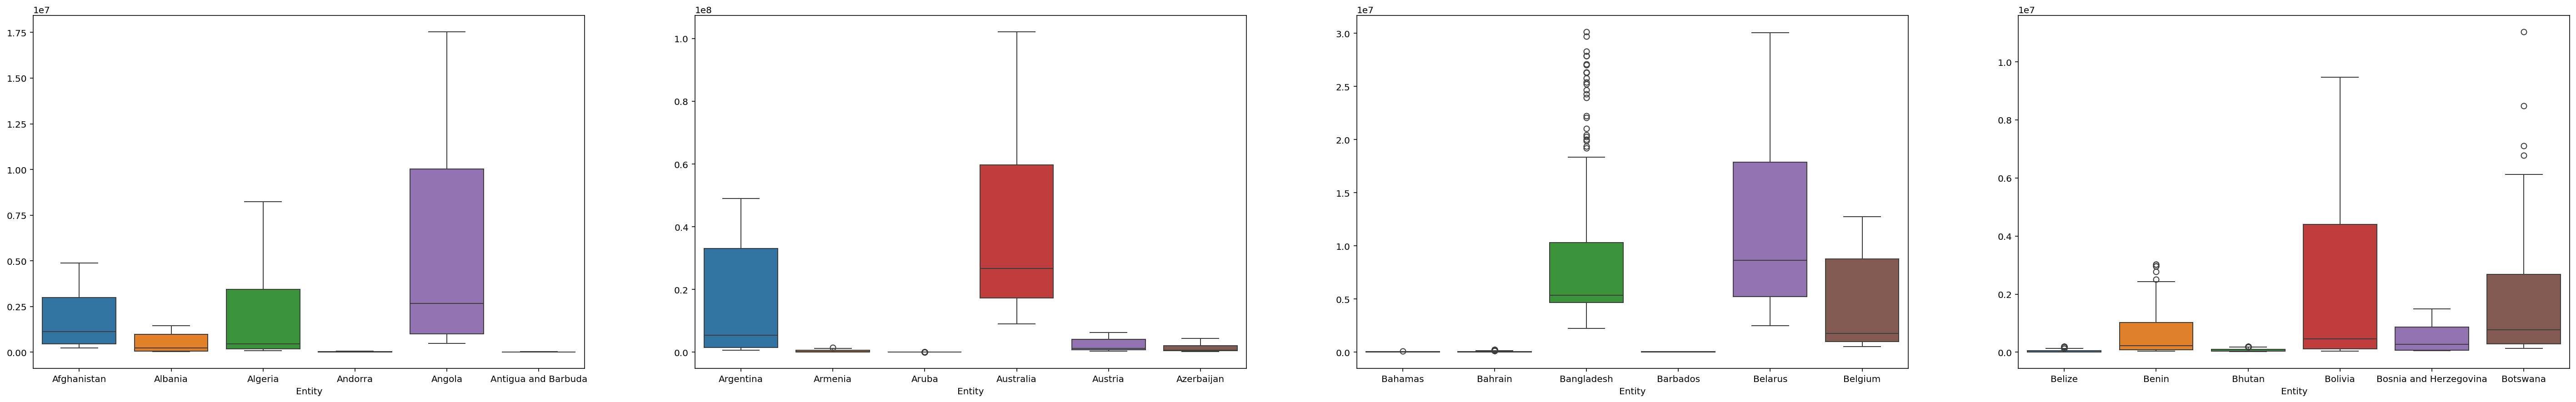

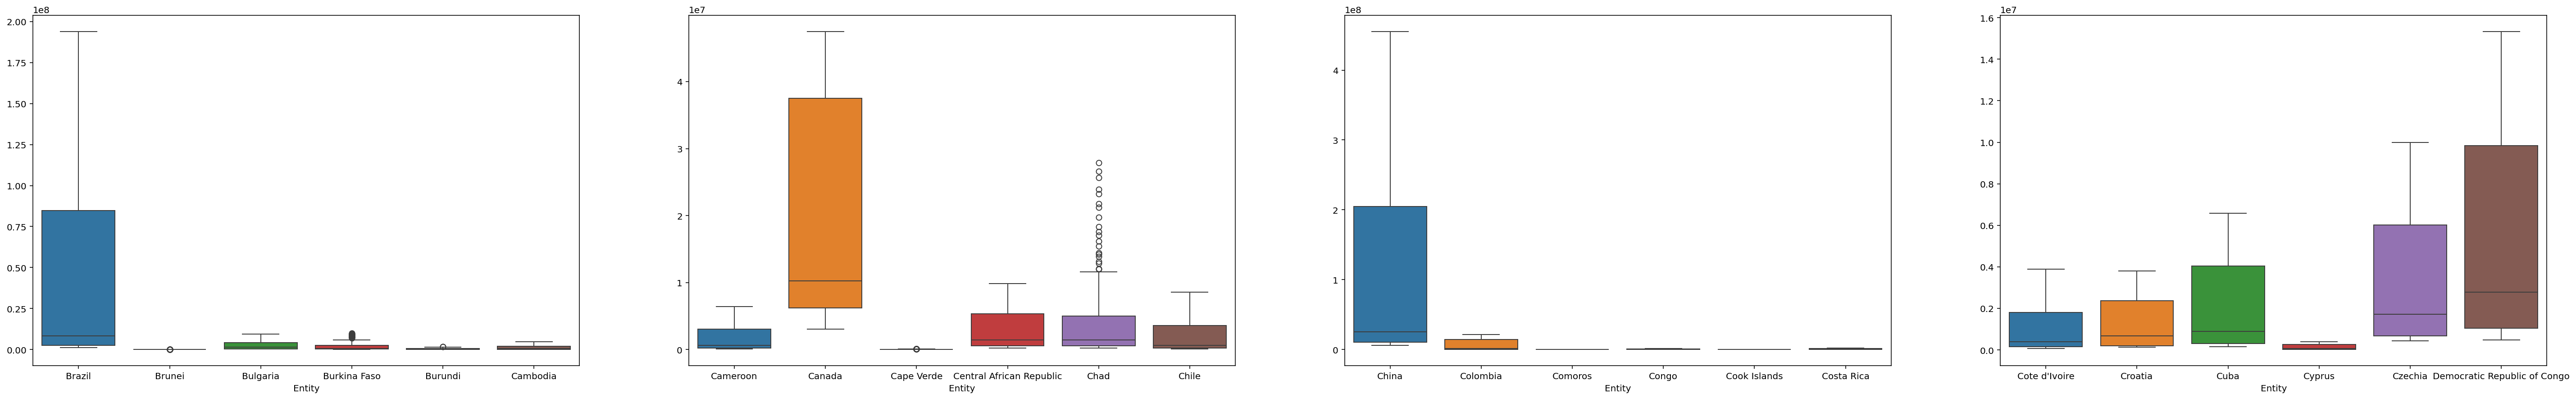

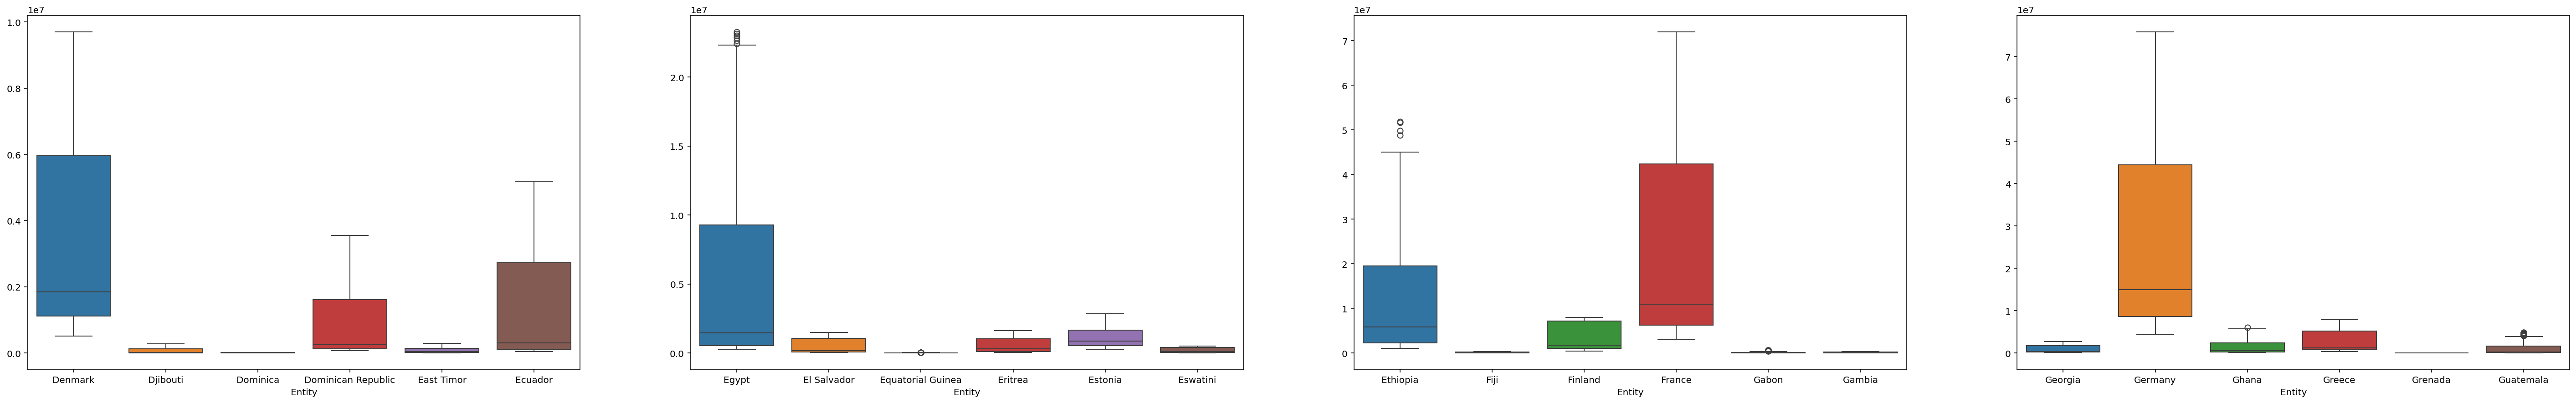

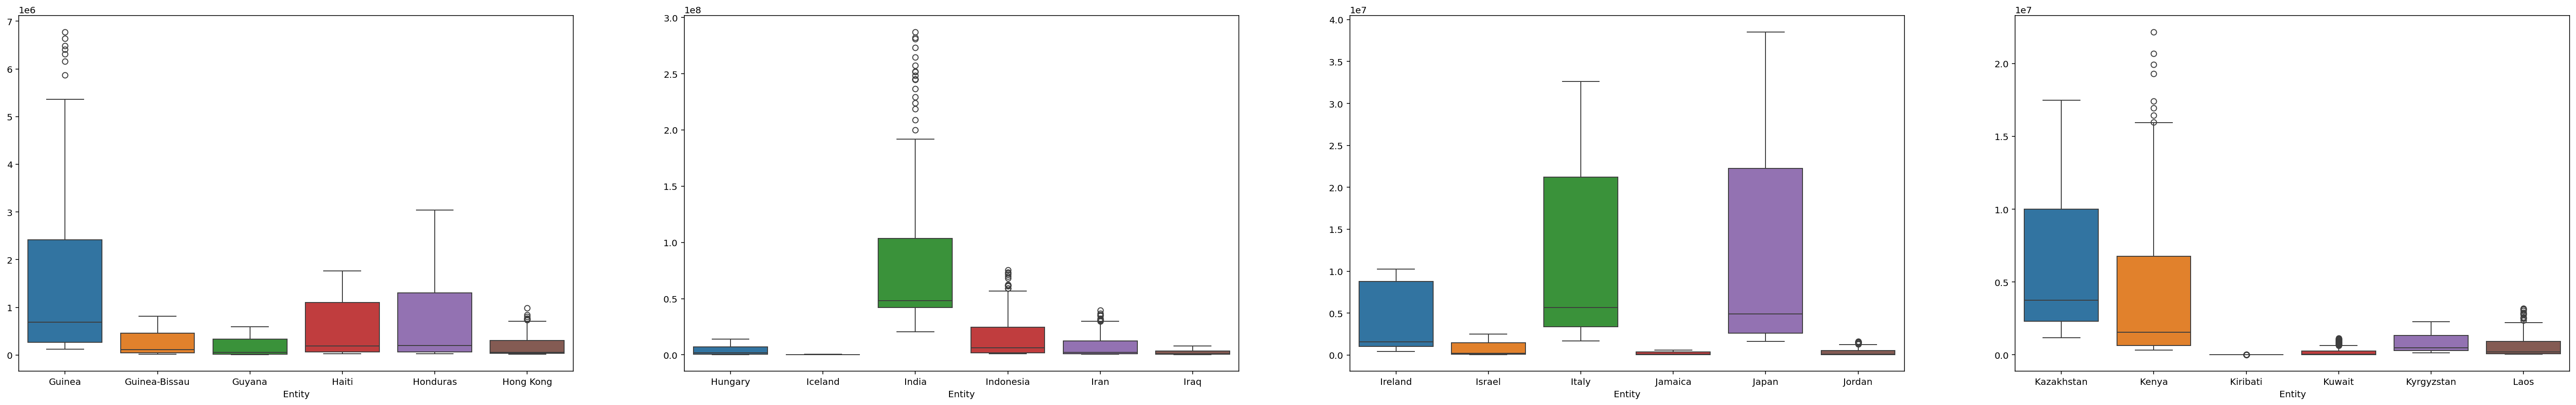

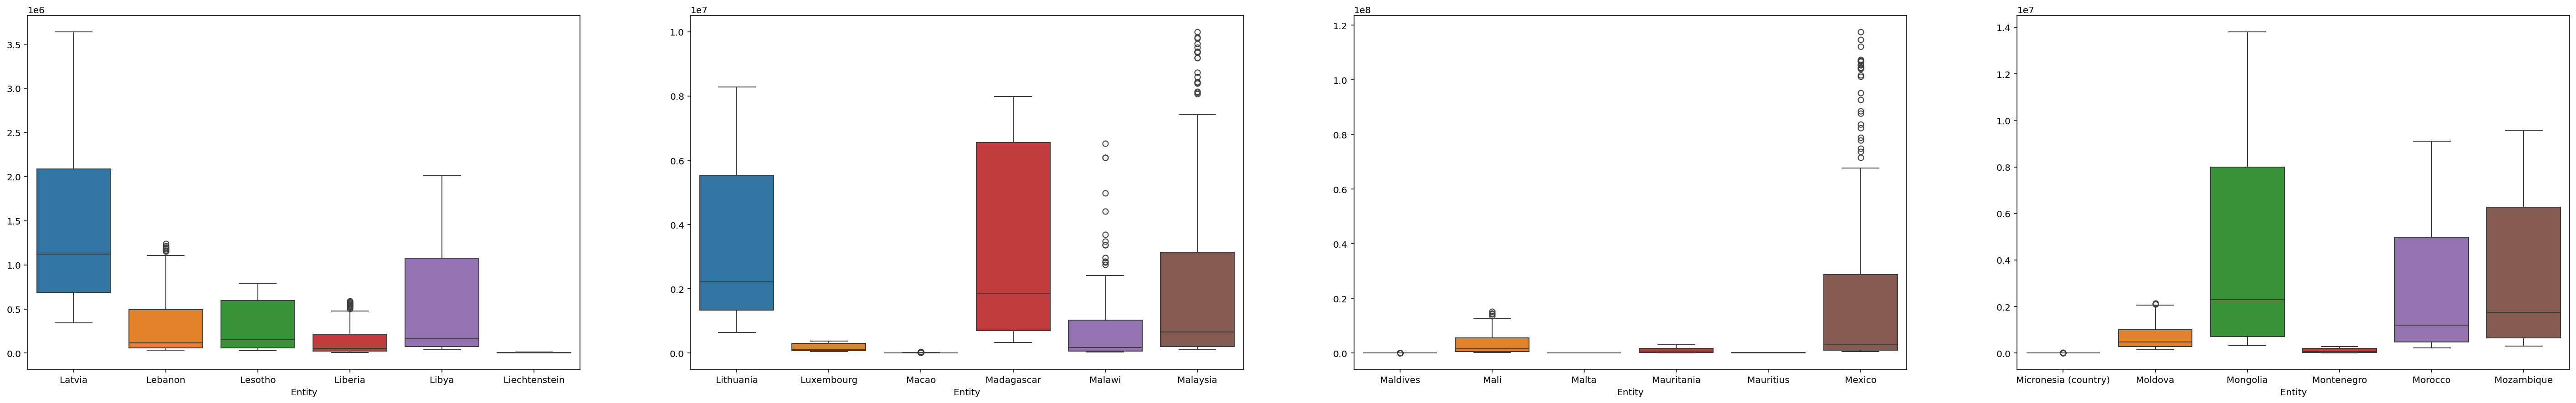

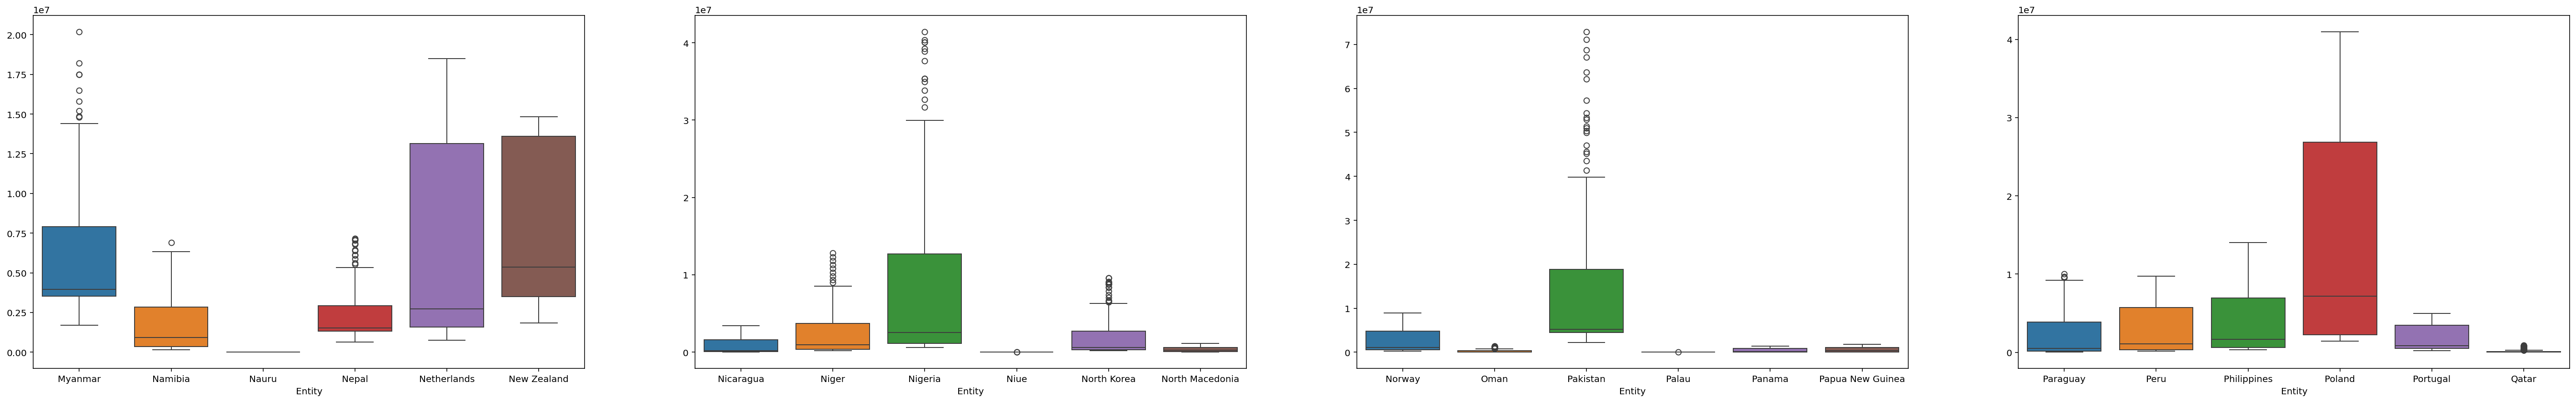

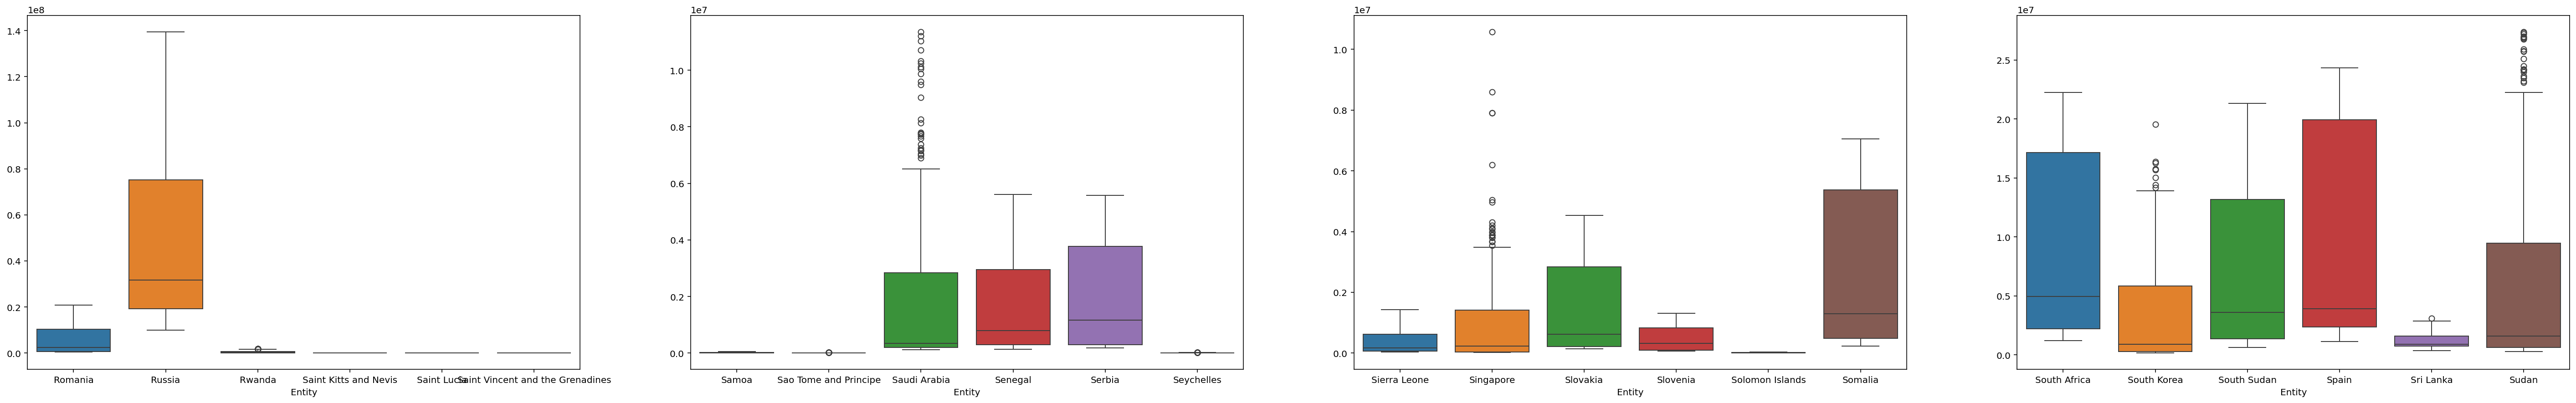

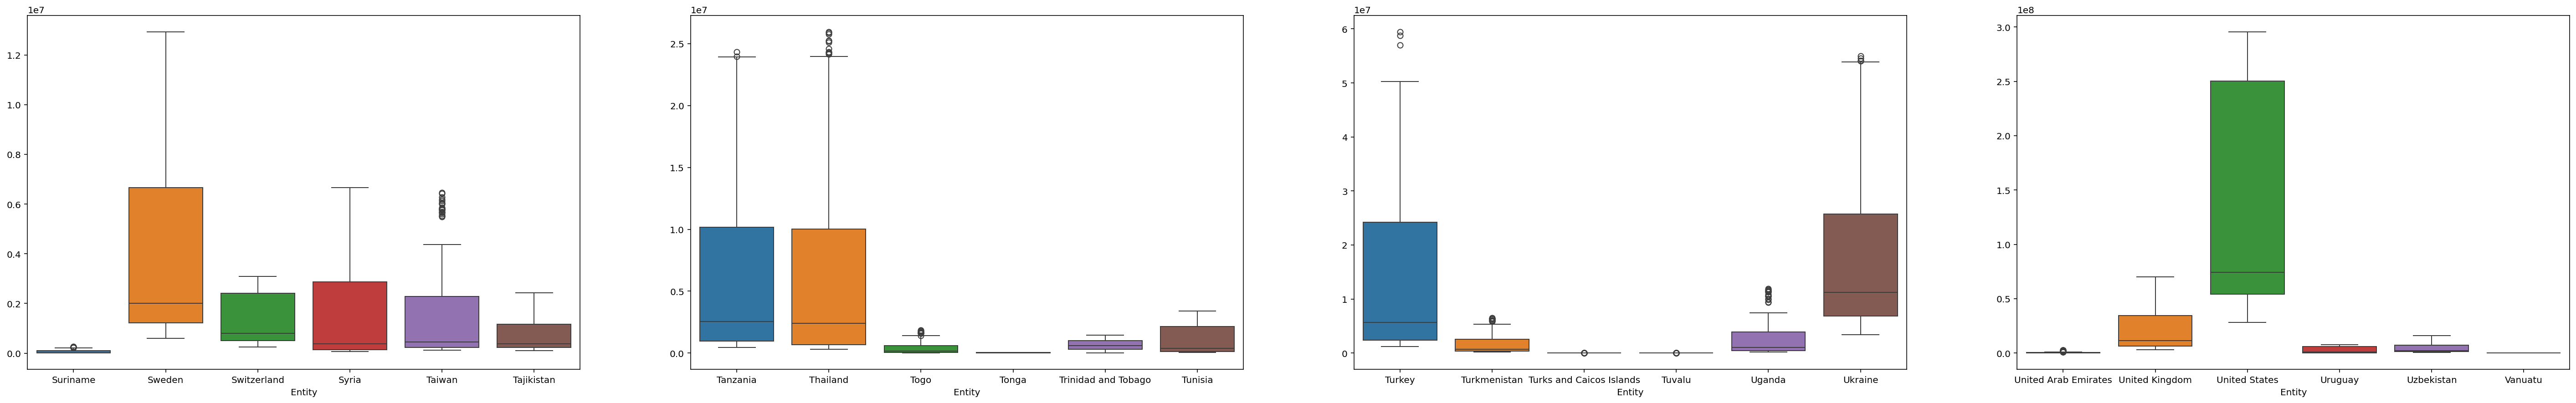

In [7]:
#Creating a boxplot using seaborn to check for any outliers in the data
j=6
k=0
for r in range(8):
  f, ax = plt.subplots(1, 4, figsize=(50,7), dpi=144)
  ax = ax.flatten()
  for c in range(4):
      sns.boxplot(data = no2_pivot.iloc[:,k:j], ax=ax[c])
      k=j
      j=j+6
  plt.show()

In [8]:
#Resetting the index so that the year will become as a column instead of index
no2_pivot = no2_pivot.reset_index()
#Using pd.melt function to unpivot the table back to its original state
no2_processed = pd.melt(no2_pivot, id_vars = ['Year'], var_name='Country', value_name = 'Emission')
print(no2_processed)

       Year      Country    Emission
0      1850  Afghanistan   223008.40
1      1851  Afghanistan   227659.61
2      1852  Afghanistan   232190.92
3      1853  Afghanistan   236528.19
4      1854  Afghanistan   240597.22
...     ...          ...         ...
34249  2018     Zimbabwe  5237749.00
34250  2019     Zimbabwe  5149571.50
34251  2020     Zimbabwe  4687377.50
34252  2021     Zimbabwe  4966384.00
34253  2022     Zimbabwe  4960561.00

[34254 rows x 3 columns]


In [9]:
#Reading the fertlizer consumption data from google drive using pd.read_csv
fertilizer_data = pd.read_csv('/content/drive/MyDrive/final_project/EML_forecast/nitrogen-fertilizer-application-per-hectare-of-cropland.csv')
print(fertilizer_data.head())
fertilizer_data.describe()


        Entity Code  Year  \
0  Afghanistan  AFG  1961   
1  Afghanistan  AFG  1962   
2  Afghanistan  AFG  1963   
3  Afghanistan  AFG  1964   
4  Afghanistan  AFG  1965   

   Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare  
0                                               0.13                                                     
1                                               0.13                                                     
2                                               0.13                                                     
3                                               0.13                                                     
4                                               0.13                                                     


,Year,Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare
count,12130.000000,12130.000000
mean,1993.246991,44.481182
std,17.548374,54.703923
min,1961.000000,0.000000
25%,1978.000000,4.990000
50%,1994.500000,25.405000
75%,2009.000000,63.020000
max,2021.000000,412.290000


In [10]:
#Renaming the column to 'Consumption'
fertilizer_data = fertilizer_data.rename(columns = {'Nutrient nitrogen N (total) | 00003102 || Use per area of cropland | 005159 || Kilograms per hectare' : 'Consumption'})
fertilizer_data = continent_drop(fertilizer_data)
print(fertilizer_data)


            Entity Code  Year  Consumption
0      Afghanistan  AFG  1961         0.13
1      Afghanistan  AFG  1962         0.13
2      Afghanistan  AFG  1963         0.13
3      Afghanistan  AFG  1964         0.13
4      Afghanistan  AFG  1965         0.13
...            ...  ...   ...          ...
10226     Zimbabwe  ZWE  2017        15.85
10227     Zimbabwe  ZWE  2018        12.22
10228     Zimbabwe  ZWE  2019        12.22
10229     Zimbabwe  ZWE  2020         9.59
10230     Zimbabwe  ZWE  2021         9.59

[10231 rows x 4 columns]


In [11]:
#Creating a pivot table with countries as columns and year as index
fertilizer_pivot = pd.pivot_table(fertilizer_data, index='Year', columns='Entity', values = 'Consumption')
print(fertilizer_pivot)
#Checking if the data contains any null values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):print(fertilizer_pivot.isna().sum())

Entity  Afghanistan  Albania  Algeria  American Samoa  Angola  \
Year                                                            
1961           0.13     6.65     1.27             NaN    0.16   
1962           0.13     4.11     2.17             NaN    0.16   
1963           0.13     4.04     2.64             NaN    0.16   
1964           0.13     3.99     2.37             NaN    0.31   
1965           0.13     3.83     1.97             NaN    0.86   
...             ...      ...      ...             ...     ...   
2017          17.80    56.28     8.27            6.77    5.92   
2018          15.06    35.59     8.26            4.35    4.74   
2019           7.45    55.07     8.25            6.81    3.63   
2020           5.33    47.38     8.25            5.64    5.09   
2021           4.12      NaN     8.25             NaN    3.62   

Entity  Antigua and Barbuda  Argentina  Armenia  Aruba  Australia  ...  \
Year                                                               ...   
1961  

In [12]:
#Calling the manage_nuul_values function to treat null values
fertilizer_pivot = manage_null_values(fertilizer_pivot)
#Checking if the data still contain any null values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):print(fertilizer_pivot.isna().sum())

Entity
Afghanistan                         0
Albania                             0
Algeria                             0
Angola                              0
Argentina                           0
Australia                           0
Austria                             0
Bahrain                             0
Bangladesh                          0
Barbados                            0
Belize                              0
Benin                               0
Bolivia                             0
Botswana                            0
Brazil                              0
Bulgaria                            0
Burkina Faso                        0
Burundi                             0
Cambodia                            0
Cameroon                            0
Canada                              0
Central African Republic            0
Chad                                0
Chile                               0
China                               0
Colombia                            0
Congo

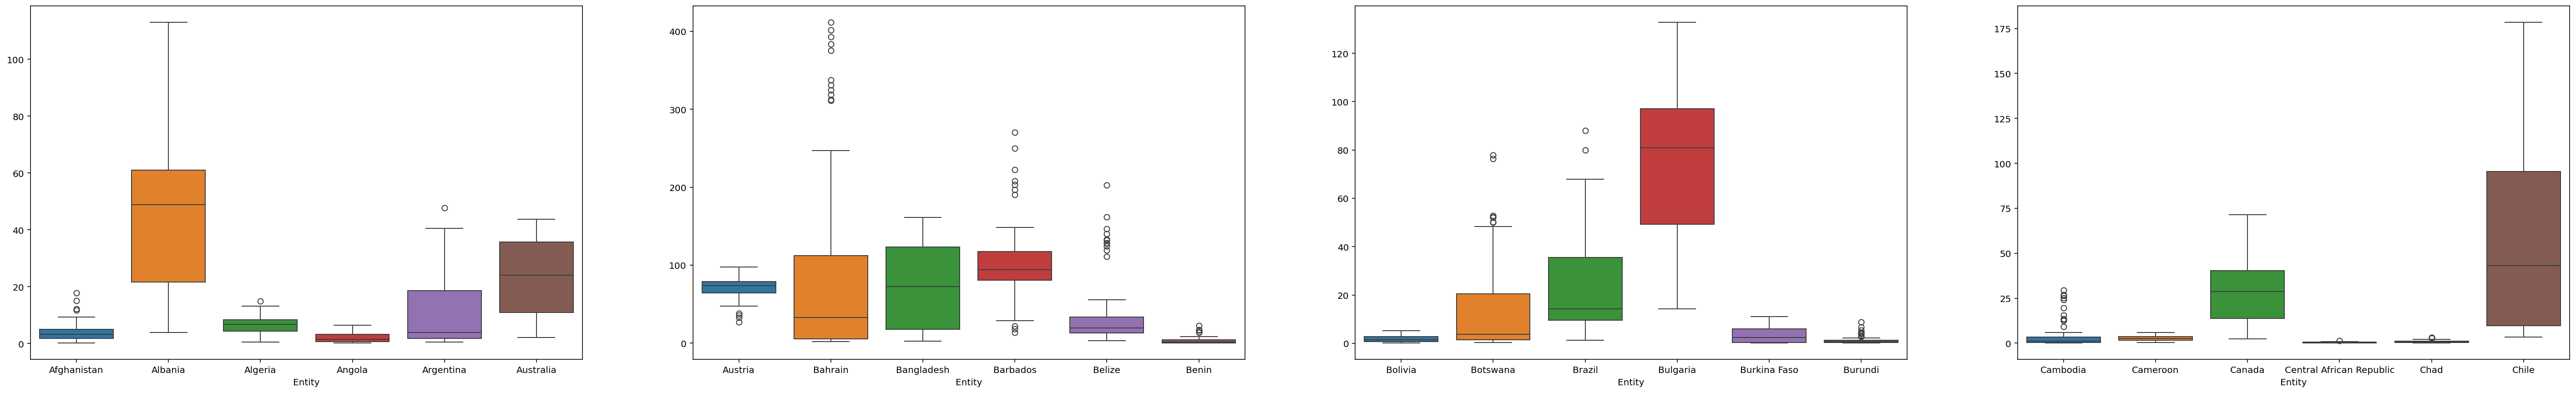

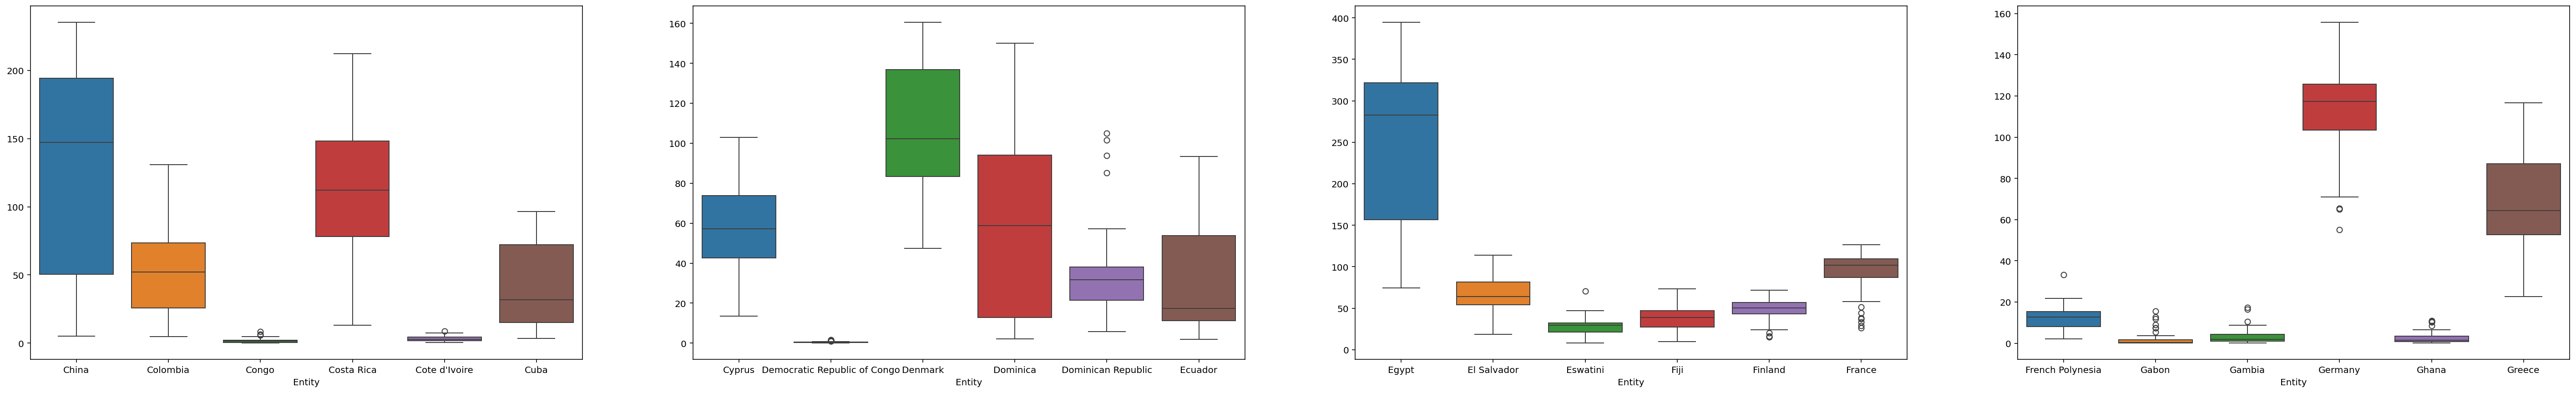

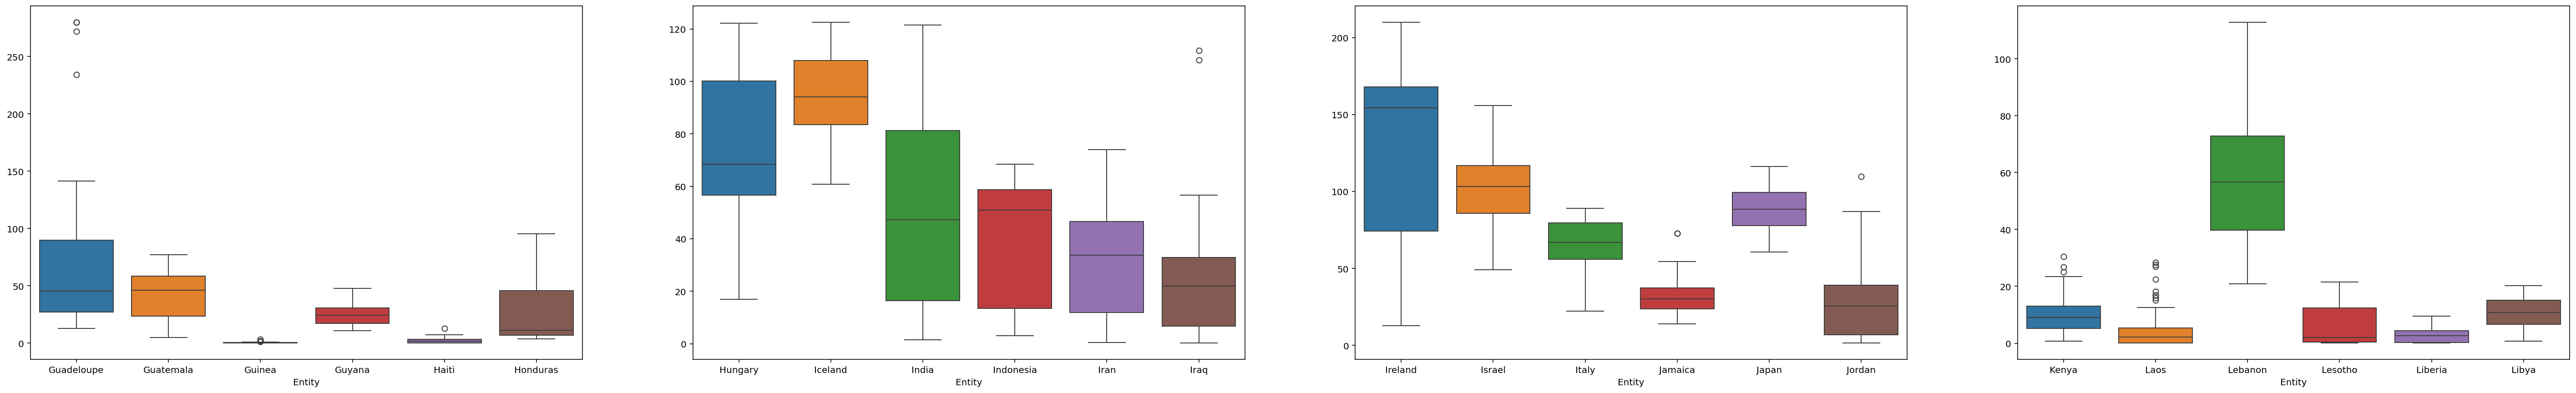

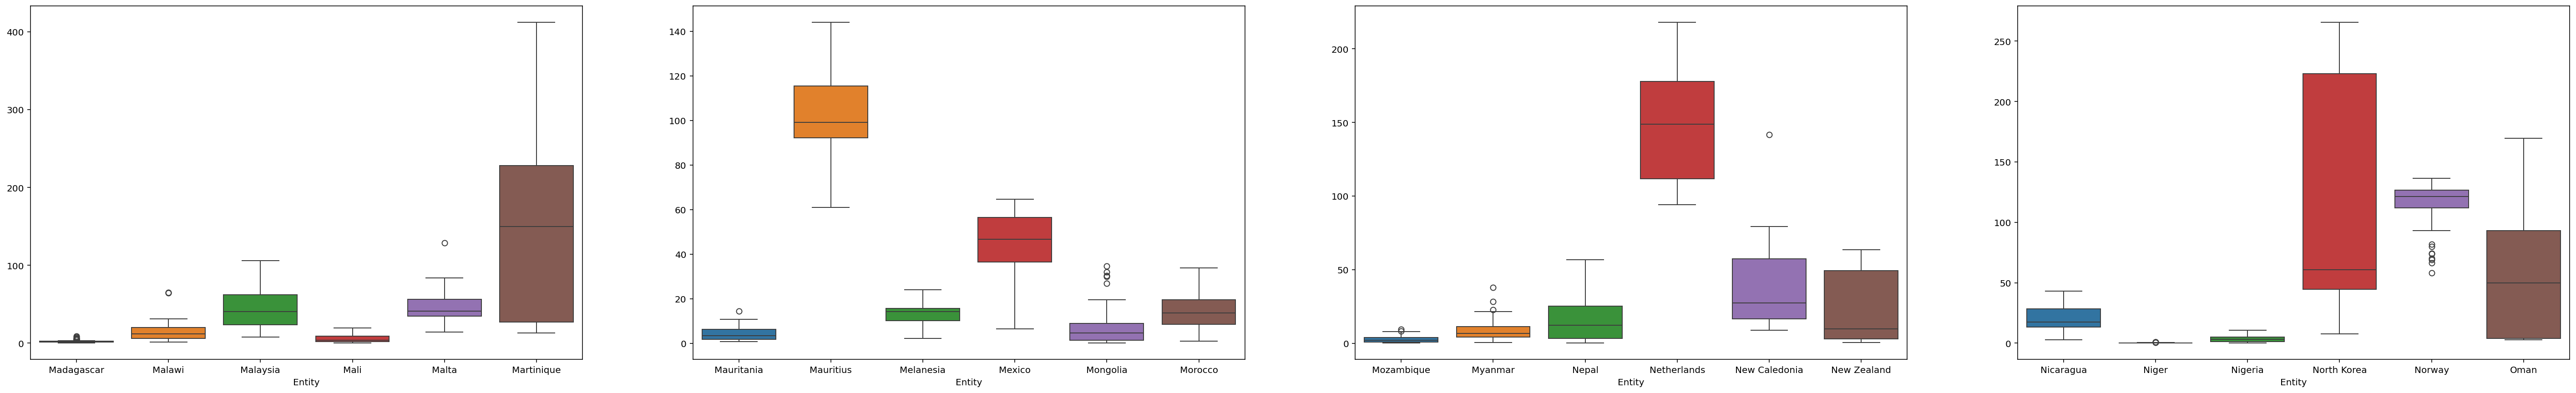

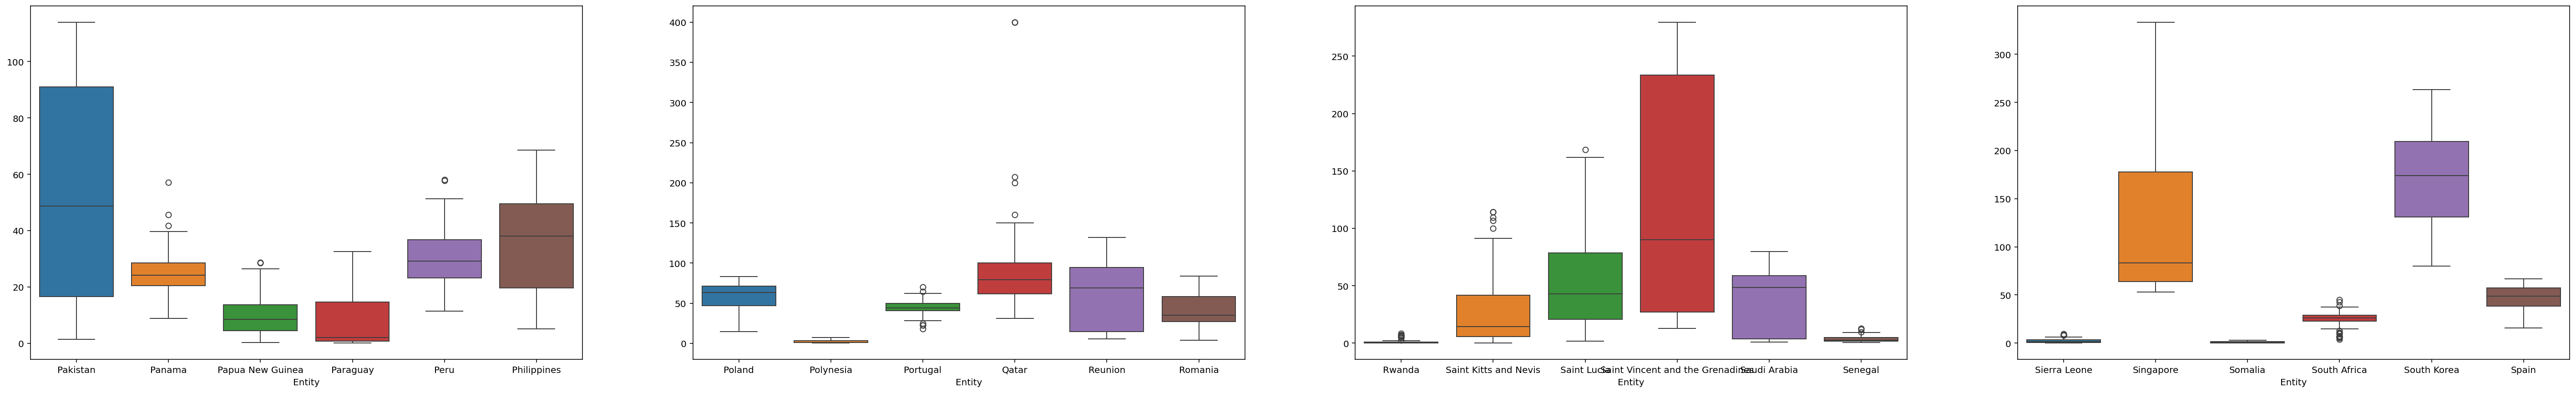

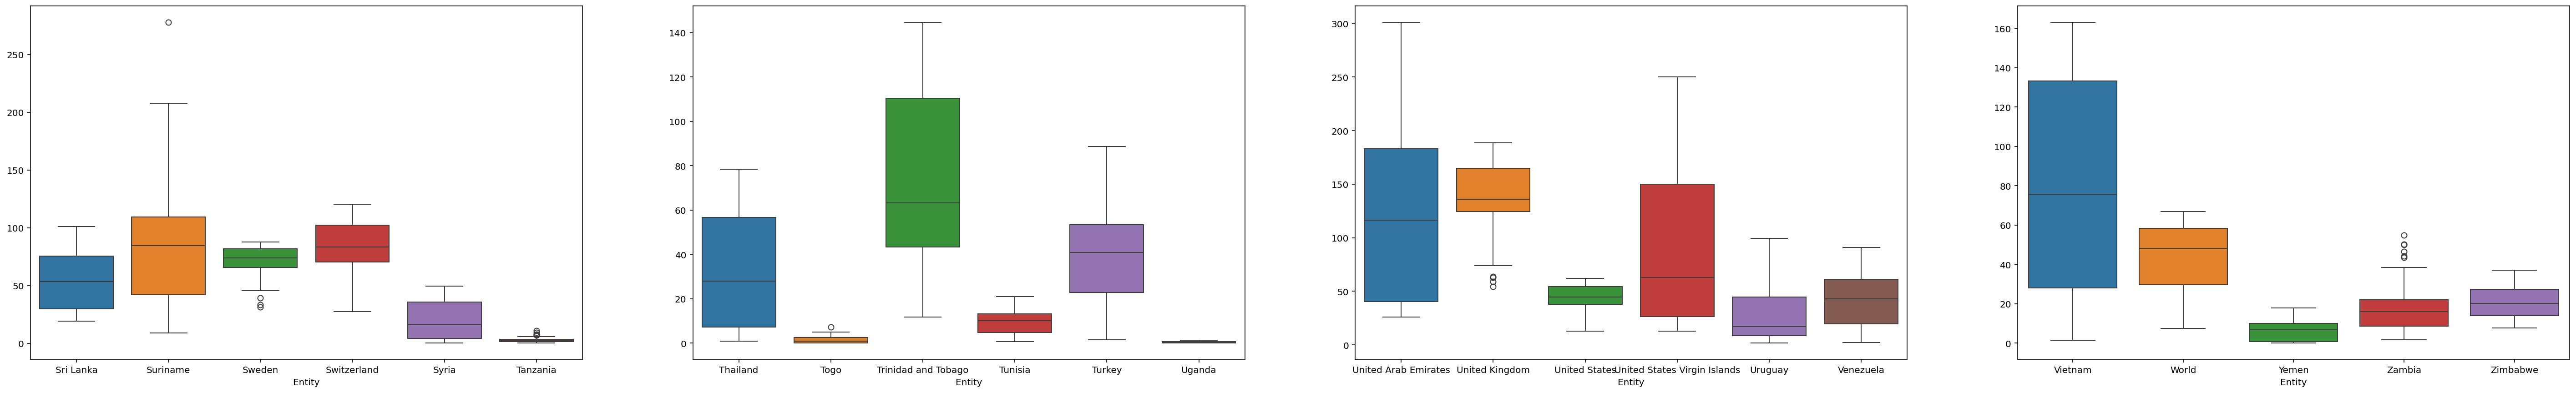

In [13]:
#Ceating a box plot using seaborn to check for any outliers
j=6
k=0
for r in range(6):
  f, ax = plt.subplots(1, 4, figsize=(50,7), dpi=144)
  ax = ax.flatten()
  for c in range(4):
      sns.boxplot(data = fertilizer_pivot.iloc[:,k:j], ax=ax[c])
      k=j
      j=j+6
  plt.show()

In [14]:
#Resetting the index to change transfrom year as a column rather than index
fertilizer_pivot = fertilizer_pivot.reset_index()
#Using pd.melt to unpivot the table
fertilizer_processed = pd.melt(fertilizer_pivot, id_vars =['Year'], var_name='Country', value_name='Fertlizer_consumption')
print(fertilizer_processed)

      Year      Country  Fertlizer_consumption
0     1961  Afghanistan                   0.13
1     1962  Afghanistan                   0.13
2     1963  Afghanistan                   0.13
3     1964  Afghanistan                   0.13
4     1965  Afghanistan                   0.13
...    ...          ...                    ...
8718  2017     Zimbabwe                  15.85
8719  2018     Zimbabwe                  12.22
8720  2019     Zimbabwe                  12.22
8721  2020     Zimbabwe                   9.59
8722  2021     Zimbabwe                   9.59

[8723 rows x 3 columns]


In [15]:
temperature_data = pd.read_csv('/content/drive/MyDrive/final_project/EML_forecast/average-monthly-surface-temperature.csv')
print(temperature_data.head())
temperature_data.describe()

        Entity Code  year         Day  Average surface temperature  \
0  Afghanistan  AFG  1940  1940-01-15                    -2.032526   
1  Afghanistan  AFG  1940  1940-02-15                    -0.733487   
2  Afghanistan  AFG  1940  1940-03-15                     1.999130   
3  Afghanistan  AFG  1940  1940-04-15                    10.199746   
4  Afghanistan  AFG  1940  1940-05-15                    17.942122   

   Average surface temperature.1  
0                       11.32767  
1                       11.32767  
2                       11.32767  
3                       11.32767  
4                       11.32767  


,year,Average surface temperature,Average surface temperature.1
count,197535.000000,197535.000000,197535.000000
mean,1981.709773,18.054742,18.060564
std,24.369841,10.250760,8.710215
min,1940.000000,-36.239986,-21.529089
25%,1961.000000,12.276010,10.549379
50%,1982.000000,22.041750,21.846956
75%,2003.000000,25.307129,25.131996
max,2024.000000,39.889305,29.794174


In [16]:
#Removing the average monthly temperature column and day column
temperature_data = temperature_data.drop(columns=['Day', 'Average surface temperature'], axis=1)
#Removing duplicate values from the table
temperature_data = temperature_data.drop_duplicates(subset=['Entity','year'])
print(temperature_data)

             Entity Code  year  Average surface temperature.1
0       Afghanistan  AFG  1940                      11.327670
12      Afghanistan  AFG  1941                      13.324721
24      Afghanistan  AFG  1942                      12.885410
36      Afghanistan  AFG  1943                      11.524734
48      Afghanistan  AFG  1944                      12.143650
...             ...  ...   ...                            ...
197482     Zimbabwe  ZWE  2020                      21.785597
197494     Zimbabwe  ZWE  2021                      21.573135
197506     Zimbabwe  ZWE  2022                      21.591951
197518     Zimbabwe  ZWE  2023                      22.349136
197530     Zimbabwe  ZWE  2024                      22.349136

[16575 rows x 4 columns]


In [17]:
#Calling the continent_drop function to remove all the non-country records
temperature_data = continent_drop(temperature_data)

In [18]:
#Creating a pivot table with countries as columns and year as index value
temperature_pivot = pd.pivot(temperature_data, index='year', columns='Entity', values='Average surface temperature.1')
print(temperature_pivot)

Entity  Afghanistan    Albania    Algeria  American Samoa   Andorra  \
year                                                                  
1940      11.327670  10.647986  21.311056       26.434393  3.409559   
1941      13.324721  10.806905  22.005445       26.394377  3.381775   
1942      12.885410  11.375268  21.872087       26.069975  4.423551   
1943      11.524734  12.312192  21.083275       26.089449  4.279320   
1944      12.143650  11.373283  21.874914       26.464602  3.574028   
...             ...        ...        ...             ...       ...   
2020      12.358914  13.342273  24.726358       26.994550  5.845164   
2021      13.982883  13.125373  25.220282       26.756380  5.152855   
2022      13.753045  13.501858  24.677412       26.570168  7.224482   
2023      13.836345  13.822647  24.874125       27.005728  7.266917   
2024      13.836345  13.822647  24.874125       27.005728  7.266917   

Entity     Angola   Anguilla  Antigua and Barbuda  Argentina   Armenia  ... 

In [19]:
#Checking if the data contains any null values
with pd.option_context('display.max_rows', None, 'display.max_columns', None):print(temperature_pivot.isna().sum())

Entity
Afghanistan                                     0
Albania                                         0
Algeria                                         0
American Samoa                                  0
Andorra                                         0
Angola                                          0
Anguilla                                        0
Antigua and Barbuda                             0
Argentina                                       0
Armenia                                         0
Australia                                       0
Austria                                         0
Azerbaijan                                      0
Bahamas                                         0
Bahrain                                         0
Bangladesh                                      0
Belarus                                         0
Belgium                                         0
Belize                                          0
Benin                                      

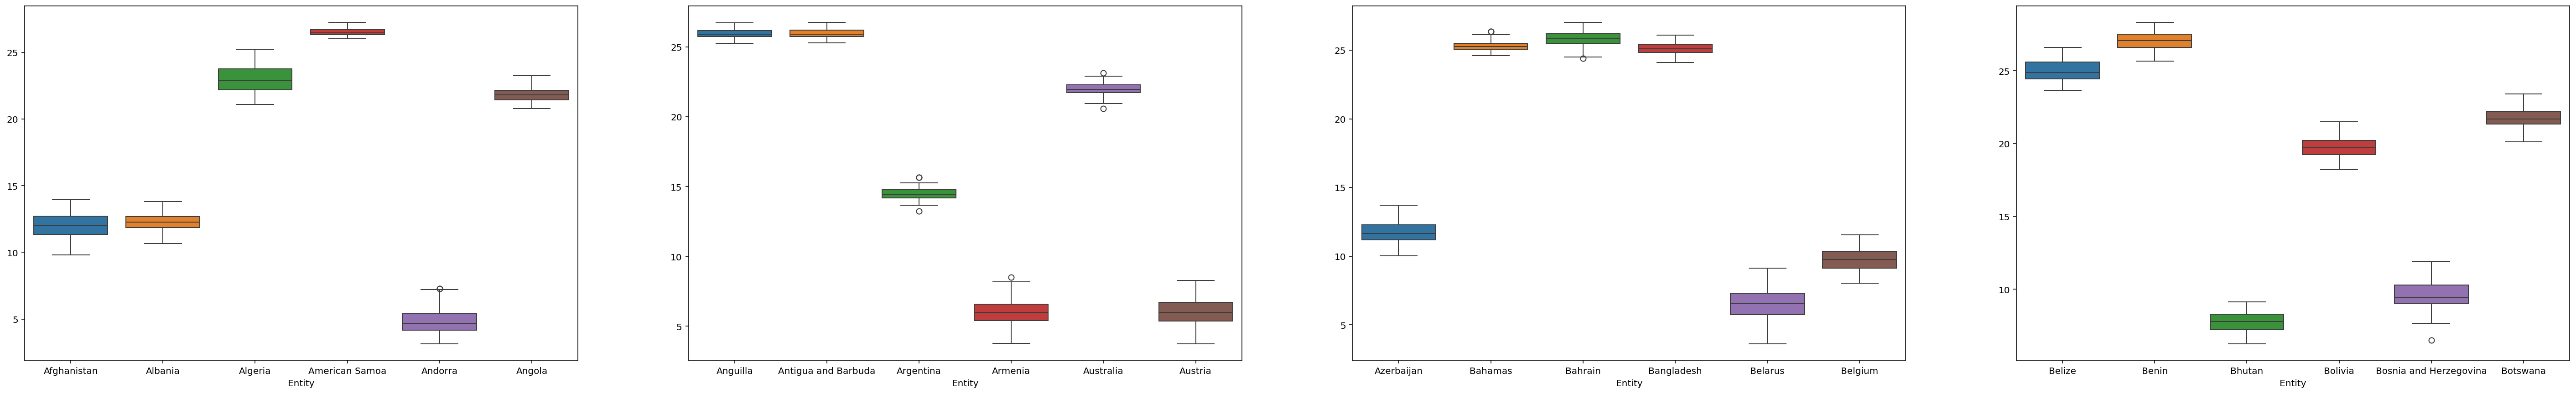

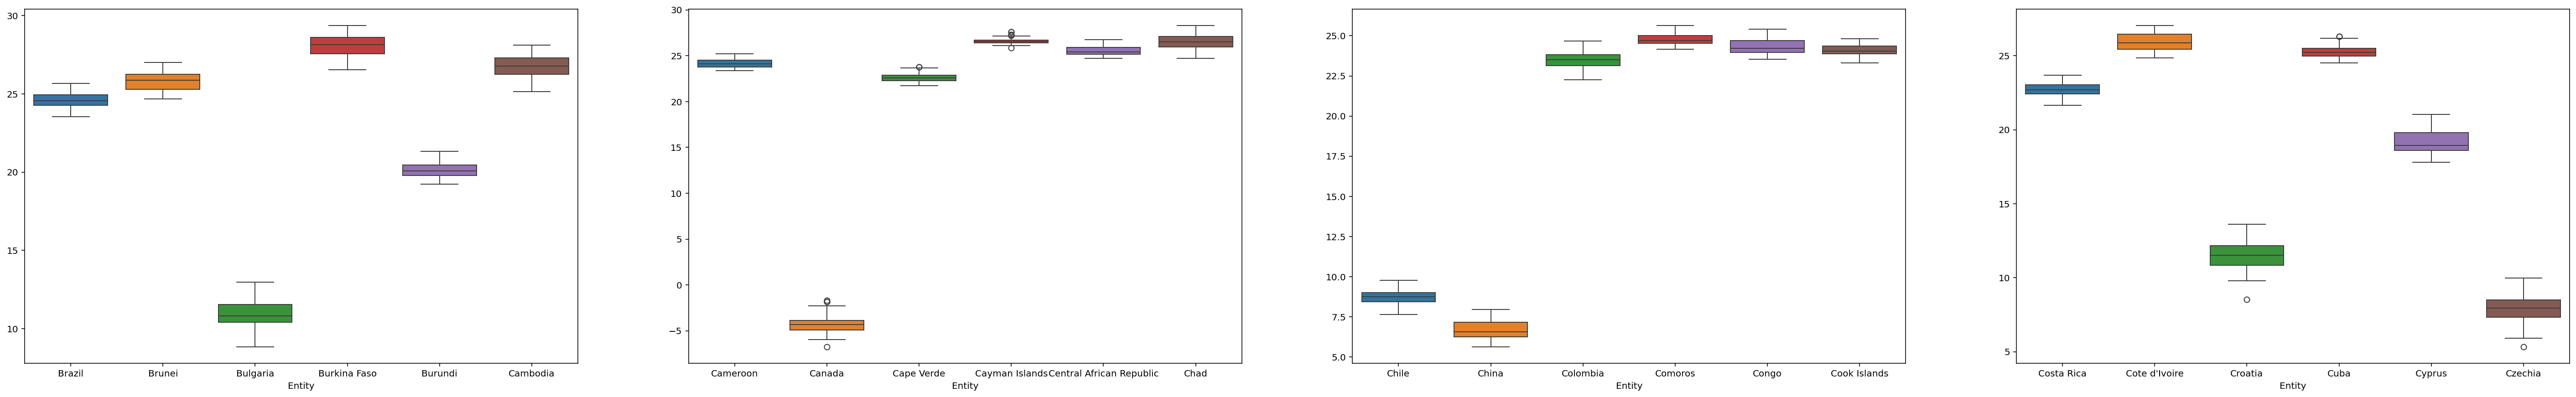

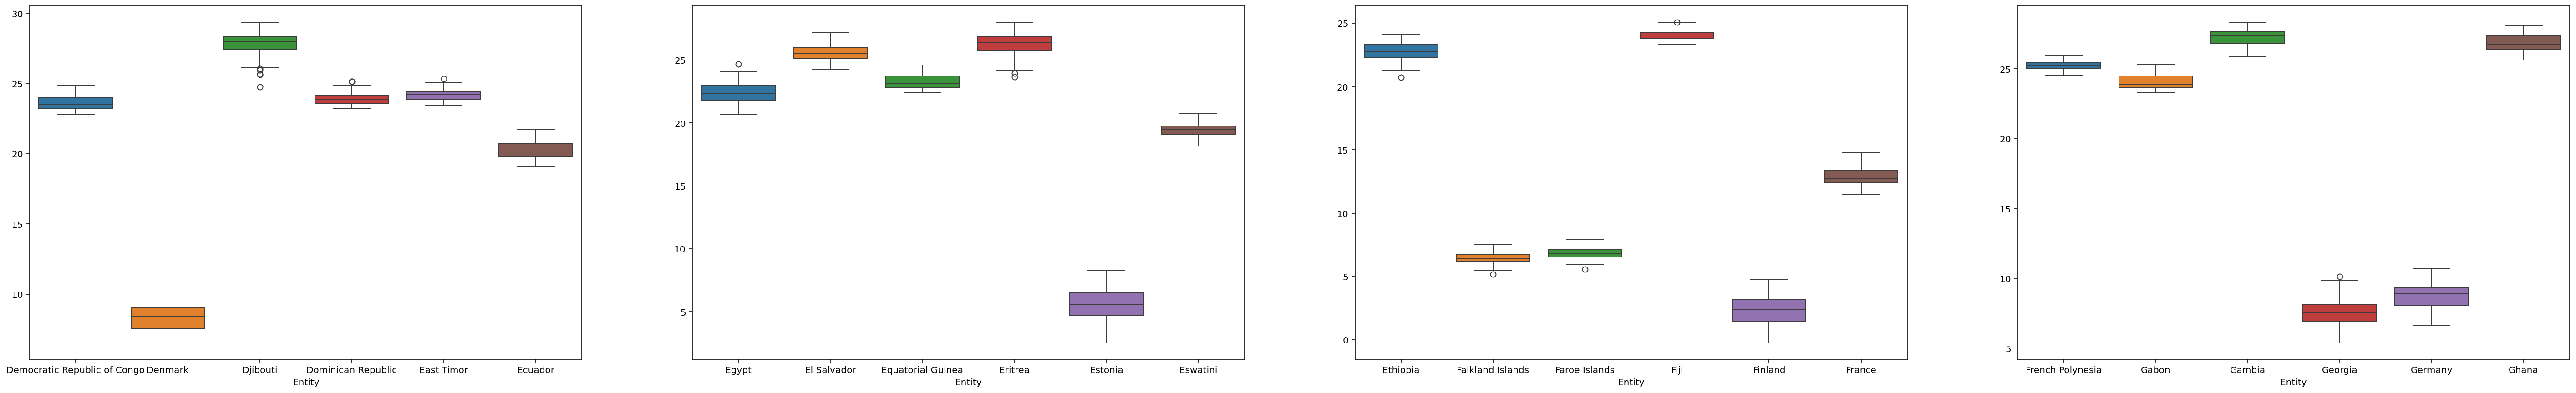

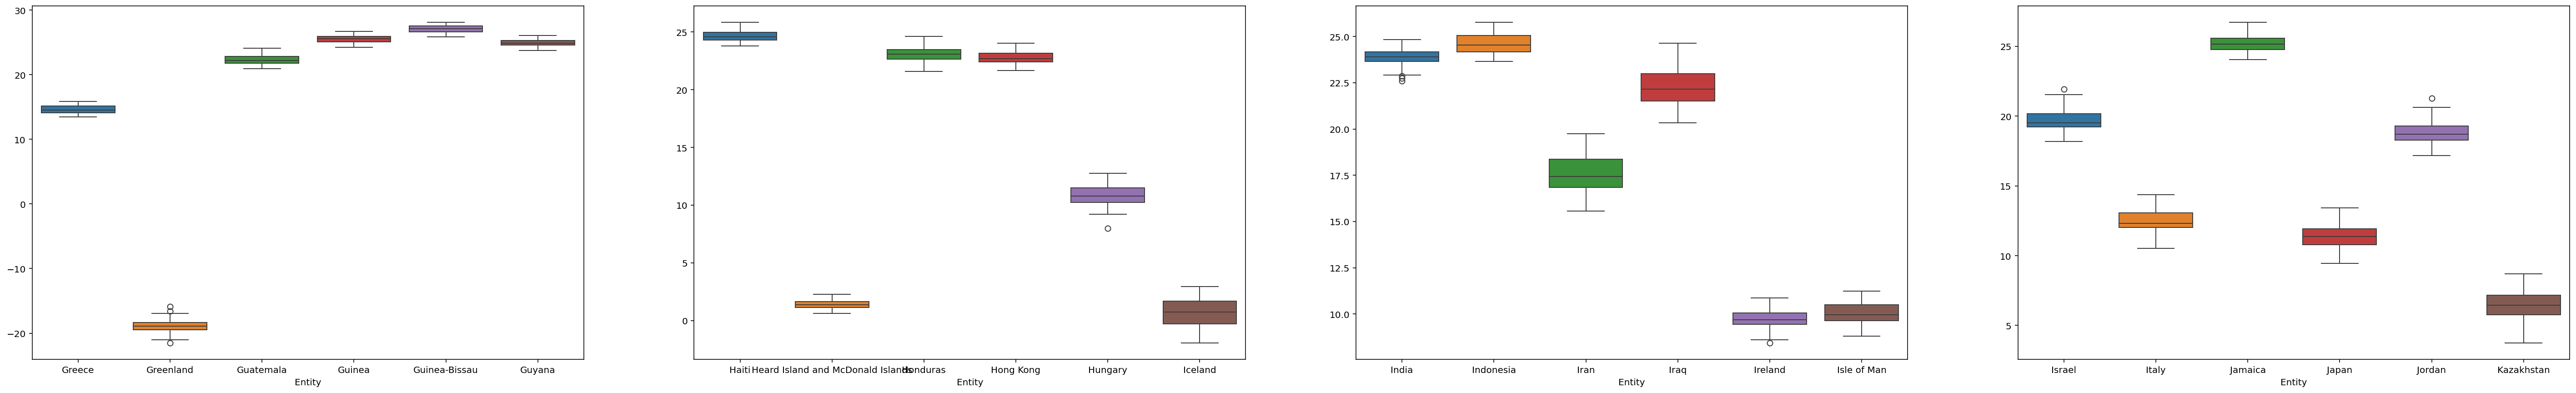

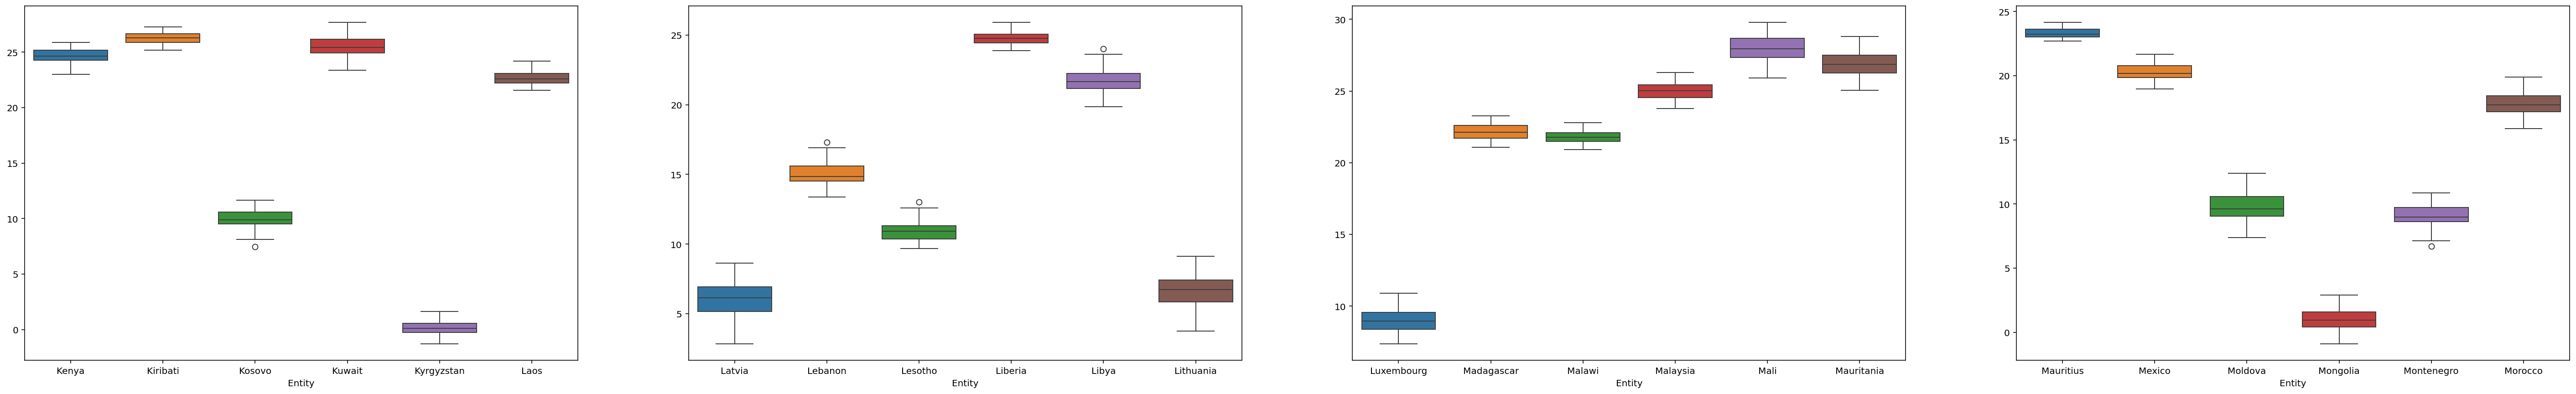

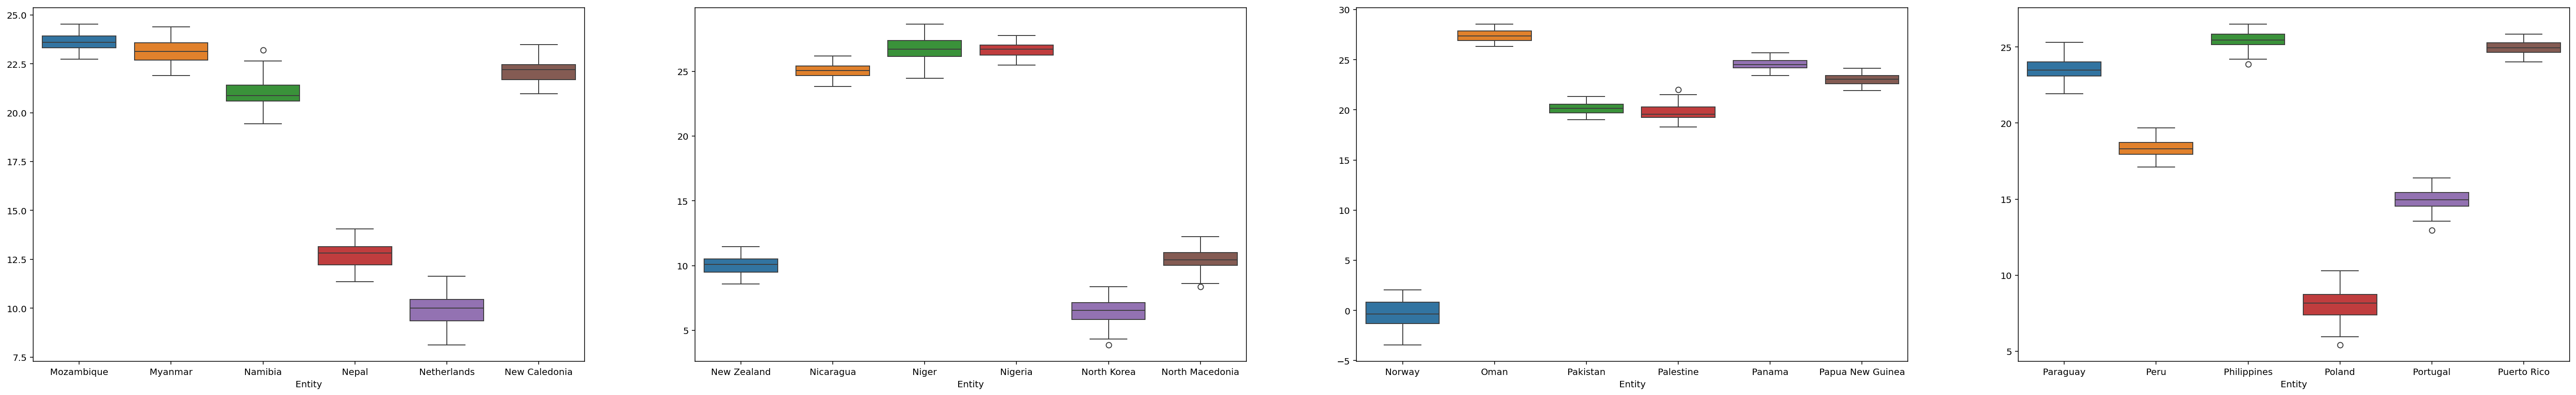

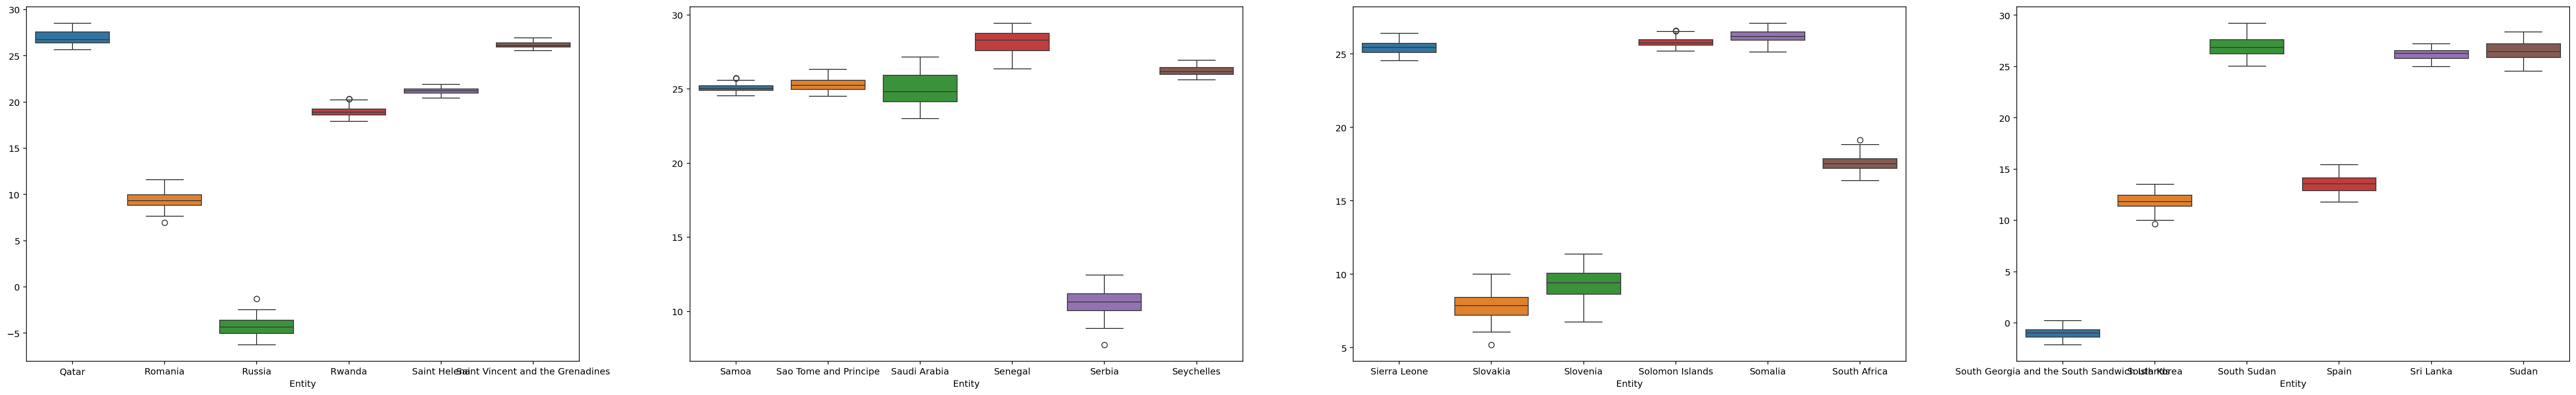

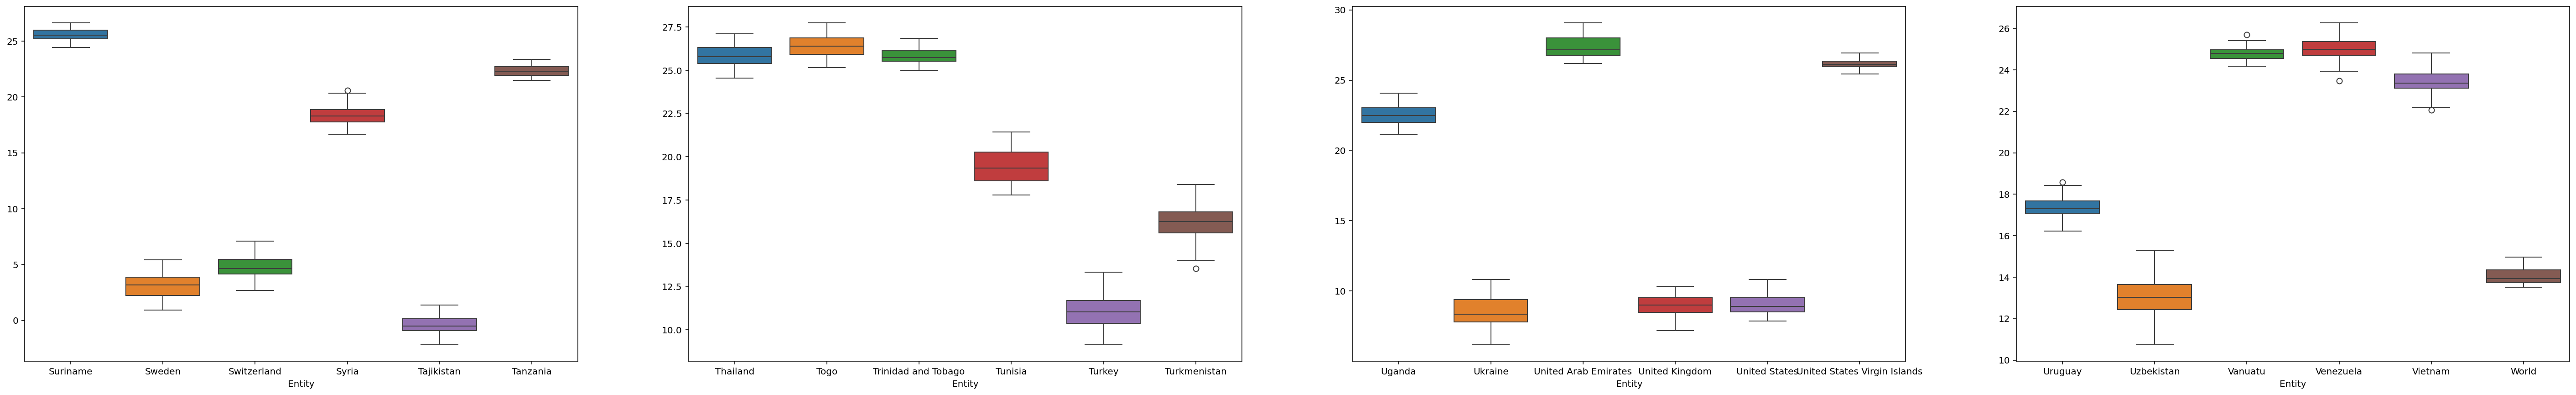

In [20]:
#Creating a boxplot to identify outliers in the data
j=6
k=0
for r in range(8):
  f, ax = plt.subplots(1, 4, figsize=(50,7), dpi=144)
  ax = ax.flatten()
  for c in range(4):
      sns.boxplot(data = temperature_pivot.iloc[:,k:j], ax=ax[c])
      k=j
      j=j+6
  plt.show()

In [21]:
#Resetting the index to trasnform the year as a column rather than index
temperature_pivot = temperature_pivot.reset_index()
#Un-pivot the table using pd.melt
temperature_processed = pd.melt(temperature_pivot, id_vars ='year', var_name='Country', value_name='Temperature')
#Renaming the year column
temperature_processed = temperature_processed.rename(columns={'year' : 'Year'})
print(temperature_processed)

       Year      Country  Temperature
0      1940  Afghanistan    11.327670
1      1941  Afghanistan    13.324721
2      1942  Afghanistan    12.885410
3      1943  Afghanistan    11.524734
4      1944  Afghanistan    12.143650
...     ...          ...          ...
16570  2020     Zimbabwe    21.785597
16571  2021     Zimbabwe    21.573135
16572  2022     Zimbabwe    21.591951
16573  2023     Zimbabwe    22.349136
16574  2024     Zimbabwe    22.349136

[16575 rows x 3 columns]


In [22]:
#Merging all the three dataframes based on Year and Country column
merged_df = pd.merge(no2_processed, fertilizer_processed, on=['Year', 'Country'])
final_df = pd.merge(merged_df, temperature_processed, on=['Year', 'Country'])
print(final_df)
forecast_data = final_df.to_excel('/content/drive/MyDrive/final_project/EML_forecast/forecast_data.xlsx')

      Year      Country   Emission  Fertlizer_consumption  Temperature
0     1961  Afghanistan  2917273.5                   0.13    11.336061
1     1962  Afghanistan  2891160.8                   0.13    11.144664
2     1963  Afghanistan  2941533.2                   0.13    12.411098
3     1964  Afghanistan  3004207.0                   0.13    10.428792
4     1965  Afghanistan  3075739.0                   0.13    11.212704
...    ...          ...        ...                    ...          ...
7864  2017     Zimbabwe  5147235.0                  15.85    21.228878
7865  2018     Zimbabwe  5237749.0                  12.22    21.909628
7866  2019     Zimbabwe  5149571.5                  12.22    22.434425
7867  2020     Zimbabwe  4687377.5                   9.59    21.785597
7868  2021     Zimbabwe  4966384.0                   9.59    21.573135

[7869 rows x 5 columns]


In [23]:
# Creating a standardized data frame by calling normalise function group by country
final_df_normalised = final_df.groupby("Country").apply(lambda x: normalise(x)).reset_index(drop=True)
print(final_df_normalised)

      Year      Country  Emission  Fertlizer_consumption  Temperature
0     1961  Afghanistan -0.712272              -1.105319    -0.917338
1     1962  Afghanistan -0.751117              -1.105319    -1.135850
2     1963  Afghanistan -0.676183              -1.105319     0.309998
3     1964  Afghanistan -0.582949              -1.105319    -1.953138
4     1965  Afghanistan -0.476538              -1.105319    -1.058171
...    ...          ...       ...                    ...          ...
7864  2017     Zimbabwe  0.400771              -0.624780     0.032740
7865  2018     Zimbabwe  0.503282              -1.094862     1.164540
7866  2019     Zimbabwe  0.403417              -1.094862     2.037056
7867  2020     Zimbabwe -0.120035              -1.435445     0.958329
7868  2021     Zimbabwe  0.195951              -1.435445     0.605094

[7869 rows x 5 columns]


In [24]:
#Creating the scatter plot to show the correlation between N2O Emission and
#fertilizer consumption across different countries
i=0
for r in range(32):
  f, ax = plt.subplots(1, 4, figsize=(30,5), dpi=144)
  ax = ax.flatten()
  for c in range(4):
    country = final_df_normalised['Country'].unique()[i]
    country_df = final_df_normalised[final_df_normalised['Country']==country]
    ax[c].scatter(x=country_df['Fertlizer_consumption'], y=country_df['Emission'])
    ax[c].set_xlabel('Fertilizer Consumption', fontsize=8)
    ax[c].set_ylabel('N2O Emission', fontsize=8)
    ax[c].set_title(country, fontsize=10)
    i=i+1
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [25]:
#Creating the scatter plot to show the correlation between N2O Emission and
#temperature across different countries
i=0
for r in range(32):
  f, ax = plt.subplots(1, 4, figsize=(30,5), dpi=144)
  ax = ax.flatten()
  for c in range(4):
    country = final_df_normalised['Country'].unique()[i]
    country_df = final_df_normalised[final_df_normalised['Country']==country]
    ax[c].scatter(x= country_df['Temperature'], y= country_df['Emission'])
    ax[c].set_xlabel('Temperature', fontsize=8)
    ax[c].set_ylabel('N2O Emission', fontsize=8)
    ax[c].set_title(country, fontsize=10)
    i=i+1
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [26]:
#Creating line plot to show the trend in N2O Emission, temperature and
#fertilizer consumption over the years across different countries
i=0
for r in range(32):
  f, ax = plt.subplots(1, 4, figsize=(30,5), dpi=144)
  ax = ax.flatten()
  for c in range(4):
    country = final_df_normalised['Country'].unique()[i]
    country_df = final_df_normalised[final_df_normalised['Country']==country]
    ax[c].plot(country_df['Year'], country_df['Fertlizer_consumption'], label="Fertilizer Consumption")
    ax[c].plot(country_df['Year'], country_df['Temperature'], label="Temperature")
    ax[c].plot(country_df['Year'], country_df['Emission'], label="NO2 Emission")
    ax[c].set_xlabel('Year', fontsize=8)
    ax[c].set_ylabel('Value', fontsize=8)
    ax[c].set_title(country, fontsize=10)
    ax[c].legend(fontsize=7)
    i=i+1
  plt.show()

Output hidden; open in https://colab.research.google.com to view.